<a href="https://colab.research.google.com/github/shuseiyokoi/data-science-portfolio/blob/main/cohort-analysis/cohort_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

“Cohort analysis is a subset of behavioral analytics that takes the data from a given data set (e.g., an EMRS, an e-commerce platform, web application, or online game) and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time span.” - Wikipedia

### Objectives

The primary objective of this analysis is to conduct cohort analysis on Japan’s population data using Python and to develop a predictive model for estimating future population trends. This involves analyzing historical census data and deriving survival rates to forecast population changes accurately.

In [3]:
# Cohort Population Analysis with Python
# Shusei Yokoi - 8/14/2020

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import xlrd
from google.colab import drive

### Data Acquisition and Preparation

The datasets used in this analysis were sourced from (e-Stat)[https://www.e-stat.go.jp/en], the official Japanese government statistics portal. Two datasets were utilized: periodic population census data from 1920 to 2005 and census data from 2010.

The analysis focuses on population changes between 1990 and 2005, using this as a basis for predicting the 2010 population. Since the census is conducted every five years, the model must estimate population changes over this period. To validate the accuracy of the model, the 2015 census serves as a benchmark, as the 2020 census was unavailable during this study.

#### Key Data Preparation Steps:

1. The initial step involved clearly defining the ideal structure of the dataset before proceeding with data cleaning. This included identifying necessary columns and rows to streamline the process and minimize time spent iterating on data cleaning.
2. The population data was filtered to focus on the years 1990–2005 and was transformed into a structured and consistent format using dplyr and tidyverse.
3. Data cleaning is a crucial and challenging part of data analysis, requiring significant effort to ensure reliability for subsequent analysis.

The processed dataset includes age-wise population data for the years of interest, which is critical for building the cohort model.


In [10]:
drive.mount('/content/drive')

# Load Data
file_path = '/content/drive/MyDrive/cohort-analysis/population_btw_1990_2005.csv'
population = pd.read_csv(file_path)

# Data Cleaning
population = population.iloc[:, 1:]
population.columns = ['Age', 'Year_1920', 'Year_1960', 'Year_1970',
                      'Year_1980', 'Year_1990', 'Year_1995', 'Year_2000', 'Year_2005']

# Subset data for analysis
population_1990to2005 = population[['Age', 'Year_1990', 'Year_1995', 'Year_2000', 'Year_2005']]
population_1990to2005 = population_1990to2005.dropna().reset_index(drop=True)

# Convert to numeric
for col in ['Year_1990', 'Year_1995', 'Year_2000', 'Year_2005']:
    population_1990to2005[col] = pd.to_numeric(population_1990to2005[col])

population_1990to2005

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Age,Year_1990,Year_1995,Year_2000,Year_2005
0,０,1213685,1191578,1171652,1056800
1,１,1260478,1201008,1166160,1091316
2,２,1301517,1185263,1192157,1115649
3,３,1343438,1208065,1189303,1149450
4,４,1373779,1209340,1184826,1164872
...,...,...,...,...,...
95,95,15613,26361,42429,75580
96,96,9943,17496,29798,54915
97,97,6348,12536,21687,38156
98,98,3962,7742,14648,26778


### Cohort Model Development

The cohort model was constructed by aligning the population data for each age group across census years. Given the five-year interval between censuses, individuals of a particular age in 1990 can be tracked to subsequent census years by advancing their age accordingly. For example, individuals aged 0 in 1990 correspond to those aged 5 in 1995.

The *shift* function in python was instrumental in shifting data columns to represent population transitions over time. The resulting cohort table captures the population dynamics across age groups for 1990, 1995, 2000, and 2005. Notably, individuals aged 84 in 1990 who survived to 99 by 2005 were included in the analysis, while those aged over 100 were excluded due to data sparsity.

In [ ]:
# Create Cohort Model
cohort_1990to2005 = population_1990to2005.copy()
cohort_1990to2005['Year_1995'] = cohort_1990to2005['Year_1995'].shift(-5)
cohort_1990to2005['Year_2000'] = cohort_1990to2005['Year_2000'].shift(-10)
cohort_1990to2005['Year_2005'] = cohort_1990to2005['Year_2005'].shift(-15)
cohort_1990to2005.tail(20)


,Age,Year_1990,Year_1995,Year_2000,Year_2005
80,80,472578,319262.0,179821.0,75580.0
81,81,422144,272306.0,142477.0,54915.0
82,82,365509,225279.0,109402.0,38156.0
83,83,325174,187097.0,84061.0,26778.0
84,84,247453,132879.0,54520.0,15792.0
85,85,226914,113845.0,42429.0,NaN
86,86,189128,88487.0,29798.0,NaN
87,87,168327,71960.0,21687.0,NaN
88,88,137602,54030.0,14648.0,NaN
89,89,111079,39480.0,9926.0,NaN


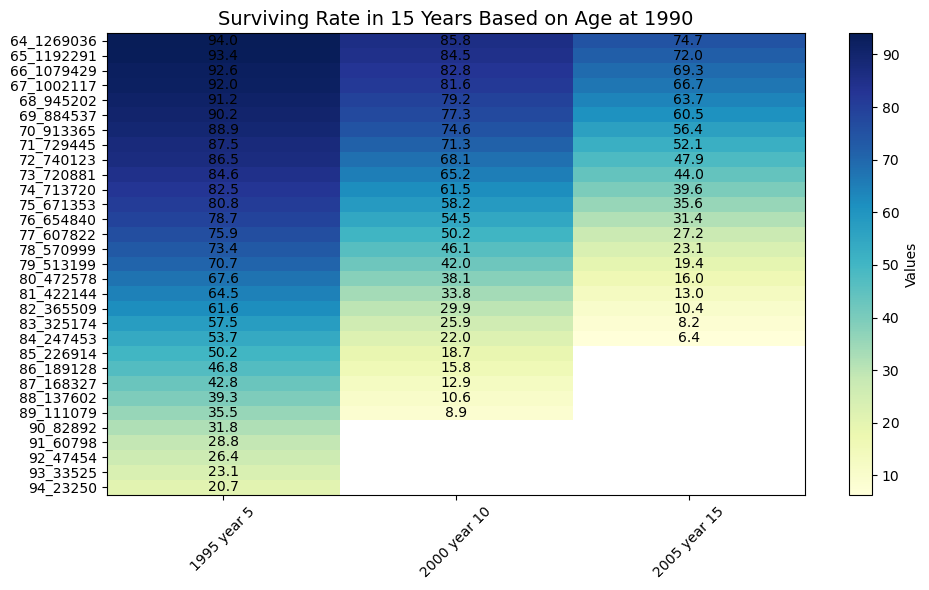

In [ ]:
# Assuming cohort_1990to2005_pct is already a DataFrame
# Selecting rows 65 to 95
temp = cohort_1990to2005_pct.iloc[64:95, :].copy()  # Python is zero-indexed

# Set row names as combined column 1 and column 2 with '_'
temp.index = temp.iloc[:, 0].astype(str) + '_' + temp.iloc[:, 1].astype(str)

# Select columns from the 3rd column onward
temp = temp.iloc[:, 2:]

# Rename columns based on the sequence
col_labels = [f"{year} year {duration}" for year, duration in zip(range(1995, 2006, 5), range(5, 16, 5))]
temp.columns = col_labels

# Plot table as a heatmap
plt.figure(figsize=(10, 6))
plt.title('Surviving Rate in 15 Years Based on Age at 1990', fontsize=14)

# Plot the table using imshow
heatmap = plt.imshow(temp.values, cmap="YlGnBu", aspect="auto")

# Add colorbar for highlighting
plt.colorbar(label="Values")

# Set row and column labels
plt.xticks(ticks=np.arange(len(temp.columns)), labels=temp.columns, rotation=45)
plt.yticks(ticks=np.arange(len(temp.index)), labels=temp.index)

# Add values (numbers) to each cell
for i in range(len(temp.index)):
    for j in range(len(temp.columns)):
        value = temp.iloc[i, j]
        if not pd.isnull(value):  # Avoid writing NaN values
            plt.text(j, i, f"{value:.1f}", ha="center", va="center", color="black")

# Final adjustments
plt.tight_layout()
plt.show()

### Population Estimation for 2010

Population estimates for 2010 were derived as follows:
	1.	The survival rate from 2000 to 2005 was calculated for each cohort.
	2.	These rates were applied to the 2005 population data to estimate the population in 2010.
	3.	The estimated population for 2010 was appended to the existing cohort table for validation.

In [ ]:
# Calculate Survival Rates
cohort_1990to2005_pct = cohort_1990to2005.copy()
for col in ['Year_1995', 'Year_2000', 'Year_2005']:
    cohort_1990to2005_pct[col] = (cohort_1990to2005_pct[col] / cohort_1990to2005_pct['Year_1990']) * 100

print(cohort_1990to2005_pct)

   Age  Year_1990   Year_1995   Year_2000   Year_2005
0    ０    1213685  101.447410  102.128312  101.688165
1    １    1260478  100.726629  100.148118  100.999462
2    ２    1301517  100.742979  100.990075  100.917775
3    ３    1343438  100.475720  100.674985  101.016645
4    ４    1373779  100.363013  100.295754  101.222395
..  ..        ...         ...         ...         ...
95  95      15613         NaN         NaN         NaN
96  96       9943         NaN         NaN         NaN
97  97       6348         NaN         NaN         NaN
98  98       3962         NaN         NaN         NaN
99  99       2356         NaN         NaN         NaN

[100 rows x 5 columns]


### Model Validation

The model’s performance was evaluated against the actual population data from the 2010 census. The residuals (differences) and percentage errors were calculated for each cohort. While the model demonstrated high accuracy for younger age groups, the error rates increased for older cohorts, likely due to the longer time span between censuses and the higher uncertainty associated with older populations.

Key Observations:
	•	Most errors remained below 10%, but some older cohorts exhibited errors as high as 37.2%.
	•	The average percentage error was approximately 6%, indicating overall strong performance, especially for younger populations.

In [ ]:
# Estimate Future Population (2010)
survival_rate_2000to2005 = cohort_1990to2005['Year_2005'] / cohort_1990to2005['Year_2000']
cohort_1990to2005['Est_Year_2010'] = (survival_rate_2000to2005 * cohort_1990to2005['Year_2005']).round()

# Load actual population data for 2010
actual_pop_2010 = np.array([1045975,1045417,1074194,1069540,1061622,1058489,1098856,1117316,1147733,1163267,1175275,1176598,1195772,1190404,1182986,1218766,1226037,1202514,1215892,1200148,1219150,1249329,1288282,1321513,1348159,1404312,1449555,1469956,1475731,1494147,1561305,1600983,1669936,1712263,1797010,1880293,1981982,2017073,1978648,1928353,1874292,1846761,1807649,1803149,1410014,1744172,1632518,1594519,1542921,1518986,1532059,1559648,1519884,1478697,1554211,1608361,1611287,1713738,1809889,1920459,2066423,2261917,2244319,2132584,1332006,1426865,1732916,1674435,1714817,1661140,1500984,1298743,1376960,1400129,1386486,1308845,1217357,1197125,1143547,1074139,990275,932127,868554,801946,743362,648870,547394,472872,411987,351465,316840,219756,192863,160027,132221,97626,77372,55845,39826,26087
])

actual_pop_2010 = pd.Series(actual_pop_2010).shift(-19).dropna()  # Adjust data alignment

# Test the Model
diff = actual_pop_2010.values - cohort_1990to2005['Est_Year_2010'].iloc[:len(actual_pop_2010)].values
diff_pct = (diff / actual_pop_2010.values) * 100


### Error Distribution Analysis

The distribution of percentage errors was plotted, highlighting the model’s strengths and limitations. The error distribution confirmed that estimates for younger cohorts were more reliable, while older age groups posed challenges due to the compounded effects of mortality and migration over the five-year intervals.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


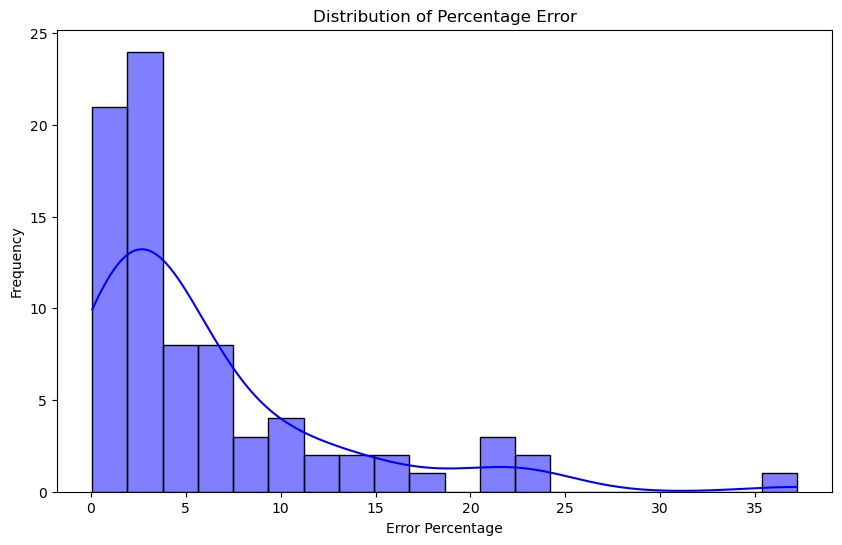

             Actual      Estimate          Diff   Diff_Pct
count  8.100000e+01  8.100000e+01      81.00000  81.000000
mean   1.300869e+06  1.306495e+06   -5626.17284   6.036861
std    5.908257e+05  5.866498e+05  127780.50581   6.865579
min    2.608700e+04  3.176700e+04 -339789.00000   0.073554
25%    1.074139e+06  1.050528e+06  -57459.00000   1.797208
50%    1.469956e+06  1.442315e+06  -10049.00000   3.390364
75%    1.712263e+06  1.711309e+06   23611.00000   7.447717
max    2.261917e+06  2.271685e+06  793289.00000  37.198488


In [ ]:

# Result Summary
result = pd.DataFrame({
    'Actual': actual_pop_2010.values,
    'Estimate': cohort_1990to2005['Est_Year_2010'].iloc[:len(actual_pop_2010)].values,
    'Diff': diff,
    'Diff_Pct': np.abs(diff_pct)
})

# Visualize Results
plt.figure(figsize=(10, 6))
sns.histplot(result['Diff_Pct'], kde=True, bins=20, color='blue')
plt.title('Distribution of Percentage Error')
plt.xlabel('Error Percentage')
plt.ylabel('Frequency')
plt.show()

# Error Summary
print(result.describe())

### Summary of Results

The model achieved an average error rate of 6%, with maximum errors observed in the oldest age groups. This analysis underscores the importance of accounting for demographic dynamics, particularly in older populations, when forecasting long-term trends. Despite these challenges, the model demonstrated robust predictive capability, particularly for younger age groups, providing valuable insights for demographic planning and policy development.